In [1]:
import pandas as pd
from sqlalchemy import select, func
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from expression_atlas_db import base, settings, utils, queries

### Calculate median expression TPM across expression_atlas_db

In [3]:
# Create sessions.

Session = base.configure(settings.db_connection_string)
SessionRedshift = base.configure(settings.redshift_connection_string)

session = Session()
session_redshift = SessionRedshift()

In [3]:
# Get all transcripts in db. 

sequenceregions_query = select(base.Transcript)

sequenceregions_df = pd.read_sql(sequenceregions_query, session.bind)

sequenceregions_df.drop(
    ['id_1', 'veliadb_id', 'assembly_id', 'type', 'gene_id'],
    axis=1,
    inplace=True,
)
sequenceregions_df

,id,transcript_id,gene_biotype
0,93994,ENST00000526982.1,protein_coding
1,94002,ENST00000526104.6,protein_coding
2,94019,ENST00000479404.6,protein_coding
3,94050,ENST00000468354.1,protein_coding
4,94076,CHS.10621.25,protein_coding
...,...,...,...
436182,530120,rna-NR_002812.3-2,lncRNA
436183,530130,rna-XR_943722.3,lncRNA
436184,530132,rna-XR_943724.3,lncRNA
436185,530137,rna-XR_007064050.1,protein_coding


In [9]:
# Pull and unpack samples from db.

samples_query = select(base.Sample, base.Study.velia_id) \
    .join(base.Study, base.Sample.study_id == base.Study.id)

samples_df = pd.read_sql(samples_query, session.bind)
samples_df = pd.concat(
    [
        samples_df, 
        samples_df["fields"].apply(lambda x: queries.unpack_fields(x, lambda y: y in ('sample_type_1', 'sample_type_2'))),
    ],
    axis=1,
)
samples_df.drop(
    ['id_1', 'study_id', 'created_at', 'alembic_id', 'fields', 'atlas_group', 'type'],
    axis=1,
    inplace=True,
)
samples_df

/home/ec2-user/miniconda3/envs/test_db/lib/python3.8/site-packages/pandas/io/sql.py:1943: SAWarning: An alias is being generated automatically against joined entity mapped class Study->study due to overlapping tables.  This is a legacy pattern which may be deprecated in a later release.  Use the aliased(<entity>, flat=True) construct explicitly, see the linked example. (Background on this error at: https://sqlalche.me/e/14/xaj2)
  return insp.has_table(name, schema or self.meta.schema)


,id,srx_id,velia_id,sample_type_1,sample_type_2
0,2,ERX2264216,ERP105501,CARTILAGE,NaN
1,3,ERX2264217,ERP105501,CARTILAGE,NaN
2,4,ERX2264220,ERP105501,CARTILAGE,NaN
3,5,ERX2264222,ERP105501,CARTILAGE,NaN
4,6,ERX2264223,ERP105501,CARTILAGE,NaN
...,...,...,...,...,...
6978,22242,SRX7434106,SRP238597,LIVER,NaN
6979,22243,SRX7434107,SRP238597,LIVER,NaN
6980,22244,SRX7434108,SRP238597,LIVER,NaN
6981,22245,SRX7434109,SRP238597,LIVER,NaN


In [10]:
# Type of samples in db. 

samples_df[['sample_type_1','sample_type_2']].value_counts()

sample_type_1    sample_type_2                 
COLON            ILEUM                             1187
                 RECTUM                             430
                 COLON                              276
ADIPOCYTE        WHITE_ADIPOCYTE                    255
BONE_MARROW      HEMATOPOIETIC_STEM_CELL             90
LUNG             LUNG_BASE                           70
                 LUNG_APEX                           67
COLON            SIGMOID_COLON                       32
ILEUM            TERMINAL_ILEUM                      32
JEJUNUM          ENTEROENDOCRINE_CELL                27
BLOOD            DENDRITIC_CELL                      24
NEUTROPHIL       NORMAL_DENSITY_NEUTROPHIL           20
COLON            BOWEL                               20
                 SIGMOID                             19
DENDRITIC_CELLS  DENDRITIC_CELL_CD5-CD163+CD14-      16
BONE_MARROW      MONOCYTIC_PRECURSOR                 16
DENDRITIC_CELLS  DENDRITIC_CELL_CD5+                 15


In [11]:
# Assign as sample_type_2 only if sample_type_2 present in existing sample_type_1.

primary_tissues = samples_df['sample_type_1'].unique()
samples_df['tissue'] = samples_df.apply(
    lambda x: x.sample_type_2 if not pd.isna(x.sample_type_2) and x.sample_type_2 in primary_tissues else x.sample_type_1, 
    axis=1,
)

In [12]:
# Assigned tissues, sample_types across exprssion atlas db. 

samples_df[['sample_type_1','sample_type_2','tissue']].value_counts()

sample_type_1    sample_type_2                   tissue         
COLON            ILEUM                           ILEUM              1187
                 RECTUM                          COLON               430
                 COLON                           COLON               276
ADIPOCYTE        WHITE_ADIPOCYTE                 ADIPOCYTE           255
BONE_MARROW      HEMATOPOIETIC_STEM_CELL         BONE_MARROW          90
LUNG             LUNG_BASE                       LUNG                 70
                 LUNG_APEX                       LUNG                 67
COLON            SIGMOID_COLON                   COLON                32
ILEUM            TERMINAL_ILEUM                  ILEUM                32
JEJUNUM          ENTEROENDOCRINE_CELL            JEJUNUM              27
BLOOD            DENDRITIC_CELL                  BLOOD                24
NEUTROPHIL       NORMAL_DENSITY_NEUTROPHIL       NEUTROPHIL           20
COLON            BOWEL                           COLON     

In [13]:
samples_df.drop('sample_type_2', inplace=True, axis=1)

In [23]:
# Pull median expression across each study, tissue combination. 

study_tissue_median_df = pd.DataFrame()

for i, g in tqdm(samples_df.groupby(['velia_id','tissue'])):
    median_df = queries.query_percentile_group(
        session,
        session_redshift,
        g['id'].tolist(),
        percentile_levels=[0.5,0.75,0.9],
    )
    median_df['tissue'] = i[1]
    median_df['velia_id'] = i[0]

    study_tissue_median_df = pd.concat(
        [
            study_tissue_median_df,
            median_df,
        ],
        axis=0,
        ignore_index=True,
    )

study_tissue_median_df

  0%|          | 0/86 [00:00<?, ?it/s]

100%|██████████| 86/86 [01:32<00:00,  1.07s/it]


,sequenceregion_id,perc_0.5,perc_0.75,perc_0.9,tissue,velia_id
0,18323,29.660220,33.270409,35.773623,CARTILAGE,ERP105501
1,119841,0.443784,1.508692,2.017650,CARTILAGE,ERP105501
2,403424,55.623770,66.181461,76.313765,CARTILAGE,ERP105501
3,426141,0.000000,0.362209,0.992801,CARTILAGE,ERP105501
4,465968,6.584602,8.466261,9.866168,CARTILAGE,ERP105501
...,...,...,...,...,...,...
12029739,268733,6.503058,8.784026,12.578419,SKELETAL_MUSCLE,SRP458076
12029740,279617,0.000000,0.442948,0.761949,SKELETAL_MUSCLE,SRP458076
12029741,320725,0.000000,0.000000,0.426946,SKELETAL_MUSCLE,SRP458076
12029742,487572,0.074869,0.112459,0.149654,SKELETAL_MUSCLE,SRP458076


In [46]:
# Merge transcript/sequenceregions with aggregated percs. 

study_tissue_median_sequenceregion_df = sequenceregions_df.loc[
    sequenceregions_df['transcript_id'].str.startswith('ENST')
].merge(
    study_tissue_median_df,
    left_on='id',
    right_on='sequenceregion_id',
).drop('id', axis=1)
study_tissue_median_sequenceregion_df

,transcript_id,gene_biotype,sequenceregion_id,perc_0.5,perc_0.75,perc_0.9,tissue,velia_id
0,ENST00000526982.1,protein_coding,93994,0.000000,0.000000,0.201666,COLON,ERP106487
1,ENST00000526982.1,protein_coding,93994,0.000000,0.000000,0.700356,ILEUM,ERP106487
2,ENST00000526982.1,protein_coding,93994,0.000000,0.100288,0.171091,LIVER,ERP109255
3,ENST00000526982.1,protein_coding,93994,0.000000,0.289369,0.963943,LIVER,ERP146053
4,ENST00000526982.1,protein_coding,93994,0.000000,0.151456,0.479214,SKELETAL_MUSCLE,ERP151282
...,...,...,...,...,...,...,...,...
5542774,ENST00000366513.9,protein_coding,514860,3.023740,4.429070,5.696470,PBMC,SRP414798
5542775,ENST00000366513.9,protein_coding,514860,1.040563,1.959071,2.888408,LUNG,SRP435935
5542776,ENST00000366513.9,protein_coding,514860,3.012283,4.262845,4.675001,SKELETAL_MUSCLE,SRP439857
5542777,ENST00000366513.9,protein_coding,514860,5.277273,5.522148,6.252261,VISCERAL_ADIPOSE_TISSUE,SRP445599


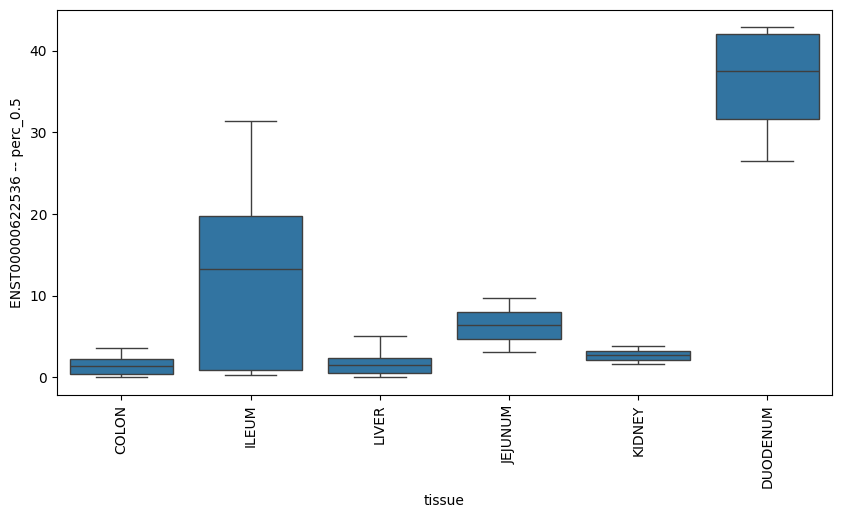

In [65]:
# Example transcript aggregated across atlas. 

fig, ax = plt.subplots(1, figsize=(10,5))
sns.boxplot(
    data=study_tissue_median_sequenceregion_df.loc[
        study_tissue_median_sequenceregion_df['transcript_id'].str.startswith('ENST00000622536'),
    ][['tissue', 'perc_0.5', 'perc_0.75', 'perc_0.9']],
    x='tissue',
    y='perc_0.5',
    ax=ax,
)
ax.set_ylabel('ENST00000622536 -- perc_0.5')
ax.tick_params(axis='x', labelrotation=90) 

In [66]:
# Aggregated on tissue across atlas.

agg_study_tissue_median_sequenceregion_df = study_tissue_median_sequenceregion_df[
    ['tissue', 'transcript_id', 'perc_0.5', 'perc_0.75', 'perc_0.9']
].groupby(['tissue', 'transcript_id']).agg(np.median).reset_index()
agg_study_tissue_median_sequenceregion_df

,tissue,transcript_id,perc_0.5,perc_0.75,perc_0.9
0,ADIPOCYTE,ENST00000000233.10,29.429032,38.431720,42.045022
1,ADIPOCYTE,ENST00000000412.8,21.245339,24.595461,26.900671
2,ADIPOCYTE,ENST00000000442.11,5.294821,6.030929,8.040702
3,ADIPOCYTE,ENST00000001008.6,6.305534,7.013751,8.451319
4,ADIPOCYTE,ENST00000001146.7,2.708765,3.935048,6.868048
...,...,...,...,...,...
2397410,VISCERAL_ADIPOSE_TISSUE,ENST00000706394.1,0.302683,0.357548,0.695384
2397411,VISCERAL_ADIPOSE_TISSUE,ENST00000706401.1,0.382365,0.504291,1.456494
2397412,VISCERAL_ADIPOSE_TISSUE,ENST00000706402.1,0.397961,0.537977,0.575950
2397413,VISCERAL_ADIPOSE_TISSUE,ENST00000706406.1,0.179401,0.237268,0.423992


In [68]:
# Save as parquet files.

for p in (0.5, 0.75, 0.9):
    agg_study_tissue_median_sequenceregion_df.pivot(
        columns='tissue',
        index='transcript_id',
        values=f'perc_{p}',
    ).fillna(0.0).to_parquet(f'20240321_expression_atlas_db_median_expression_perc_{p}.parq')